## Experiment

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import scipy as sp
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

from sklearn.svm import SVR
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
import torch
df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
df=df.iloc[:1000]
train,test = train_test_split(df, train_size=0.7,random_state=1)
train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
train_x

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
731,39.93176,43.28746,-13.38596,11.97077,39.47386,-15.98213,0.40450,-0.12974,4.93046,8.47701,...,9.28421,-125.31252,0.10776,112.07104,0.58354,128.69854,-37.50035,4.97255,-73.38973,-5.31664
716,46.74950,53.94547,25.02572,5.29242,-36.49030,-2.30921,-0.88374,7.94827,2.77896,5.21121,...,-6.69378,-114.22822,170.00155,5.53618,-12.34778,18.59814,-34.67413,6.49130,-49.10779,-2.61190
640,26.02330,-201.77563,-128.76849,26.31990,63.19943,-33.42568,-20.38217,-15.65645,35.54939,21.00675,...,20.10206,-13.31202,-22.88050,99.55618,6.30266,-105.03800,57.34783,9.21763,-205.96332,21.07824
804,47.80721,25.07585,33.84950,8.05847,-22.52360,3.74708,-21.39957,-14.34260,24.15216,2.84670,...,3.71892,-203.19986,-12.75812,14.11742,-8.29798,-73.19181,-158.66941,-3.79311,-180.22609,-12.45983
737,40.19555,22.55823,-22.31865,-16.40915,20.24315,-25.18230,-1.08735,-2.01056,9.99175,9.27890,...,8.87001,-58.76444,-60.51858,81.75608,-1.32502,36.14569,33.95389,6.52971,25.39161,8.16208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,45.93913,19.88129,51.47329,44.70062,7.87333,38.07456,10.32526,-15.60014,15.21450,-8.71651,...,16.54059,-128.53880,251.82840,22.90044,11.47945,145.29346,46.63635,33.09373,-248.67078,0.35662
72,48.61503,60.89685,-4.13356,7.76381,-6.11871,-14.68743,11.85668,8.17211,6.15722,7.37379,...,-14.75838,6.07177,41.87603,-70.27975,-13.59340,13.63338,73.66982,11.31753,55.91604,-0.60016
908,52.08806,41.42045,24.18691,-7.90194,-7.97742,-27.57139,11.58830,0.34746,1.19699,-0.69531,...,2.51542,23.88389,18.32899,-24.27133,7.22198,-15.91165,-29.66592,2.09806,38.53232,0.92214
235,31.84167,-89.55516,47.90171,1.36908,-19.85127,38.35041,-36.09192,12.50563,4.25735,9.29543,...,37.36157,-586.29171,120.67061,234.89404,-56.33737,-195.16410,262.17781,-18.54742,57.71193,23.59455


## SVR & KRR

In [130]:
svr = GridSearchCV(
    SVR(gamma=0.1),
    param_grid={"C": np.logspace(0, 2, 20), "gamma": np.logspace(-2, 0, 10)},
)

t0 = time.time()
svr.fit(train_x, train_y)
svr_fit = time.time() - t0
y_svr=svr.predict(test_x)
svrmse=mean_squared_error(test_y,y_svr)
print(f"Best SVR with params: {svr.best_params_} and testMSE: {svrmse:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

Best SVR with params: {'C': 78.47599703514611, 'gamma': 0.01} and testMSE: 178.359
SVR complexity and bandwidth selected and model fitted in 48.723 s


In [256]:
y_svr=svr.predict(train_x)
svrmse=mean_squared_error(train_y,y_svr)
print(f"trainMSE: {svrmse:.3f}")

trainMSE: 0.010


In [277]:
kr = GridSearchCV(
    KernelRidge(gamma=0.1),
    param_grid={"alpha": np.logspace(-2, 0, 20), "gamma": np.logspace(-2, 0, 10)},
)
t0 = time.time()
kr.fit(train_x, train_y)
kr_fit = time.time() - t0
y_kr=kr.predict(test_x)
krmse=mean_squared_error(test_y,y_kr)
print(f"Best KRR with params: {kr.best_params_} and testMSE: {krmse:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

Best KRR with params: {'alpha': 0.012742749857031334, 'gamma': 0.01} and testMSE: 29017.555
KRR complexity and bandwidth selected and model fitted in 10.848 s


In [279]:
y_kr=kr.predict(train_x)
krmse=mean_squared_error(train_y,y_kr)
print(f"trainMSE: {krmse:.3f}")

trainMSE: 18473.940


## DNN (to be improved) 

## DNN - direct data - a little faster

In [354]:
import torch
from torch.utils.data import TensorDataset,Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

train_x = torch.from_numpy(train_x.to_numpy()).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
test_x= torch.from_numpy(test_x.to_numpy()).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


In [391]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, 90)
        self.fc2 = nn.Linear(90, 45)
        self.fc3 = nn.Linear(45, 22)
        self.fc4 = nn.Linear(22, 11)
        self.fc5 = nn.Linear(11, 5)
        self.fc6 = nn.Linear(5, 2)
        self.fc7 = nn.Linear(2, 1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return torch.relu(self.fc7(x))

net = Net()
print(net)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)
 
net = net.to(device)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.5) #optim.Adam(...)
criterion = criterion.to(device)
 
for epoch in range(100):    
    # Compute prediction error
    y_pred = net(train_x)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, train_y)
    # Backpropagation 
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0: 
        y_test_pred = net(test_x)
        y_test_pred = torch.squeeze(y_test_pred)
 
        test_loss = criterion(y_test_pred, test_y)
        print(f'''epoch {epoch}
              Train set - loss: {train_loss}
              Test  set - loss: {test_loss}
              ''')

Net(
  (fc1): Linear(in_features=90, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=45, bias=True)
  (fc3): Linear(in_features=45, out_features=22, bias=True)
  (fc4): Linear(in_features=22, out_features=11, bias=True)
  (fc5): Linear(in_features=11, out_features=5, bias=True)
  (fc6): Linear(in_features=5, out_features=2, bias=True)
  (fc7): Linear(in_features=2, out_features=1, bias=True)
)
epoch 0
              Train set - loss: 3989269.25
              Test  set - loss: 3975271.25
              
epoch 10
              Train set - loss: 3716952.25
              Test  set - loss: 3686440.0
              
epoch 20
              Train set - loss: 3429563.5
              Test  set - loss: 3401364.25
              
epoch 30
              Train set - loss: 3164361.75
              Test  set - loss: 3138317.25
              
epoch 40
              Train set - loss: 2919668.75
              Test  set - loss: 2895612.75
              
epoch 50
              Train se

## DNN - with 'dataloader' and a batch_size

In [349]:
import torch
from torch.utils.data import TensorDataset,Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(train_x, train_y),batch_size=10, shuffle=True)
test_loader = DataLoader(mydataset(test_x, test_y),batch_size=10, shuffle=False)

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, 90)
        self.fc2 = nn.Linear(90, 45)
        self.fc3 = nn.Linear(45, 22)
        self.fc4 = nn.Linear(22, 11)
        self.fc5 = nn.Linear(11, 5)
        self.fc6 = nn.Linear(5, 2)
        self.fc7 = nn.Linear(2, 1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return self.fc7(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.5) #optim.Adam(...)


for epoch in range(100): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            print(f'''epoch {epoch}
                Train set - loss: {train_loss}
                Test  set - loss: {test_loss}
                ''')
            break

Net(
  (fc1): Linear(in_features=90, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=45, bias=True)
  (fc3): Linear(in_features=45, out_features=22, bias=True)
  (fc4): Linear(in_features=22, out_features=11, bias=True)
  (fc5): Linear(in_features=11, out_features=5, bias=True)
  (fc6): Linear(in_features=5, out_features=2, bias=True)
  (fc7): Linear(in_features=2, out_features=1, bias=True)
)
epoch 0
                Train set - loss: 2311296.5
                Test  set - loss: 2286688.0
                
epoch 10
                Train set - loss: 8128.6015625
                Test  set - loss: 8099.7890625
                
epoch 20
                Train set - loss: 229.3594512939453
                Test  set - loss: 208.5589141845703
                
epoch 30
                Train set - loss: 95.95110321044922
                Test  set - loss: 195.15823364257812
                
epoch 40
                Train set - loss: 442.9690856933594
                Test  s

## kernel machine 1 - network learning

In [223]:
class KernelNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, 90)
        self.fc2 = nn.Linear(90, 45)
        self.fc3 = nn.Linear(45,22)
        self.fc4 = nn.Linear(22, 11)
        self.fc5 = nn.Linear(11, 5)
        self.fc6 = nn.Linear(5, 2)
        self.fc7 = nn.Linear(2, 1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return torch.sigmoid(self.fc7(x))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)

criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.5) #optim.Adam(...)
for epoch in range(100): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
            test_loss = criterion(y_test_pred,y)
            print(f'''epoch {epoch}
                Train set - loss: {train_loss}
                Test  set - loss: {test_loss}
                ''')
            break


## kernel machine 2 - mean estimation

one layer machine for different Nystroem

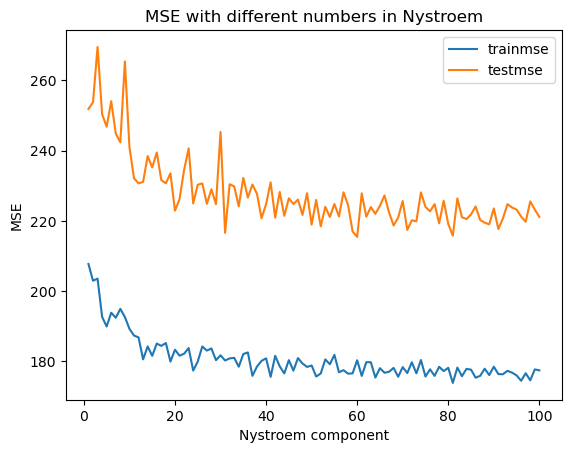

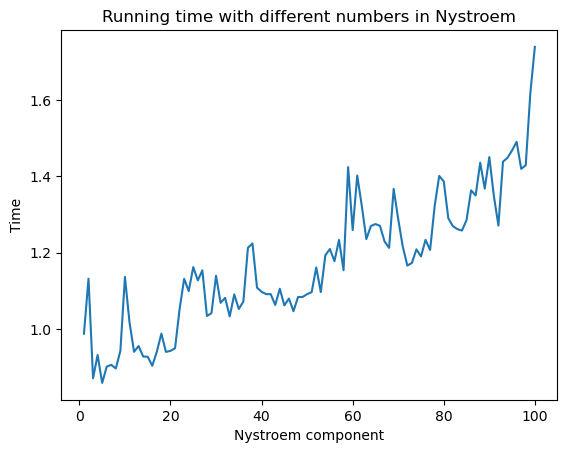

In [ ]:
kr =KernelRidge(kernel="rbf")
Layer=1
m0set=np.linspace(1,100,100)
m0set=m0set.astype(int)
gamma0=0.1
n0=32
trainmse=[]
testmse=[]
t=[]
for m0 in m0set:
    t0 = time.time()
    for i in range(n0):
        feature_map_nystroem = Nystroem(gamma=gamma0,n_components=m0)
        train_xtransformed = feature_map_nystroem.fit_transform(train_x)
        test_xtransformed = feature_map_nystroem.fit_transform(test_x)
        kr.fit(train_xtransformed, train_y)
        if i==0:
            yl_kr=kr.predict(test_xtransformed)
            yl_kltrain=kr.predict(train_xtransformed)
        else:
            yl_kr=yl_kr+kr.predict(test_xtransformed)
            yl_kltrain=yl_kltrain+kr.predict(train_xtransformed) 
    y_kr=yl_kr/n0
    y_krtrain=yl_kltrain/n0
    kernel_fit = time.time() - t0
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

plt.plot(m0set,trainmse)
plt.plot(m0set,testmse)
plt.legend(["trainmse","testmse"])
plt.xlabel("Nystroem component")
plt.ylabel("MSE")
plt.title("MSE with different numbers in Nystroem")
plt.show()

plt.plot(m0set,t)
plt.xlabel("Nystroem component")
plt.ylabel("Time")
plt.title("Running time with different numbers in Nystroem")
plt.show()


one fixed structure

In [4]:
kr =KernelRidge(kernel="rbf")
Layer=3
m0=32
gamma0=0.1
n0=32
t0 = time.time()

for l in range(Layer):  #ml points, nl sampling
    if l==0:
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            if i==0:
                yl_kr=kr.predict(test_xtransformed)
                yl_kltrain=kr.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
        
        y_kr=yl_kr/n0
        y_krtrain=yl_kltrain/n0
        
    else:
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            if i==0:
                yl_kr=kr.predict(test_xtransformed)
                yl_kltrain=kr.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
        
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**(l-1),n_components=m0*2**(l-1))
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            
            yl_kr=yl_kr-kr.predict(test_xtransformed)
            yl_kltrain=yl_kltrain-kr.predict(train_xtransformed)
            
        y_kr=y_kr+yl_kr/n0
        y_krtrain=y_krtrain+yl_kltrain/n0
kernel_fit = time.time() - t0

krmse=mean_squared_error(train_y,y_krtrain)
print(f"trainMSE: {krmse:.3f}")
krmse=mean_squared_error(test_y,y_kr)
print(f"testMSE: {krmse:.3f}")
print("Kernel machine complexity and model fitted in %.3f s" % kernel_fit)

trainMSE: 189.543
testMSE: 263.771
Kernel machine complexity and model fitted in 6.142 s


In [50]:
kr =KernelRidge(kernel="rbf")
Layer=3
m0=32
gamma0=0.1
n0=32
t0 = time.time()

for l in range(Layer):  #ml points, nl sampling
    if l==0:
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            if i==0:
                yl_kr=kr.predict(test_xtransformed)
                yl_kltrain=kr.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
        
        y_kr=yl_kr/n0
        y_krtrain=yl_kltrain/n0
        
    else:
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            if i==0:
                yl_kr=kr.predict(test_xtransformed)
                yl_kltrain=kr.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
        
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**(l-1),n_components=m0*2**(l-1))
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            
            yl_kr=yl_kr-kr.predict(test_xtransformed)
            yl_kltrain=yl_kltrain-kr.predict(train_xtransformed)
            
        y_kr=y_kr+yl_kr/n0
        y_krtrain=y_krtrain+yl_kltrain/n0
kernel_fit = time.time() - t0

krmse=mean_squared_error(train_y,y_krtrain)
print(f"trainMSE: {krmse:.3f}")
krmse=mean_squared_error(test_y,y_kr)
print(f"testMSE: {krmse:.3f}")
print("Kernel machine complexity and model fitted in %.3f s" % kernel_fit)

trainMSE: 195.720
testMSE: 251.834
Kernel machine complexity and model fitted in 6.446 s


different layer

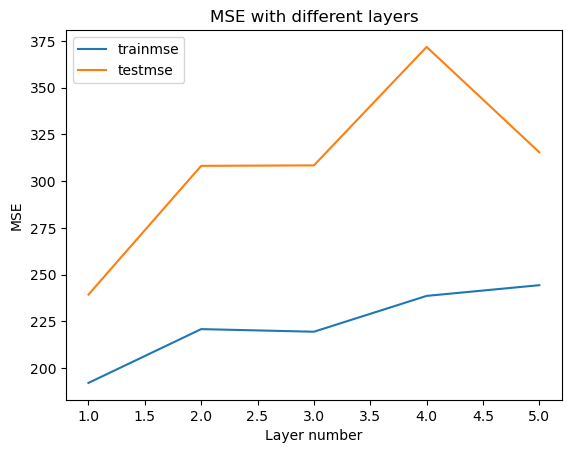

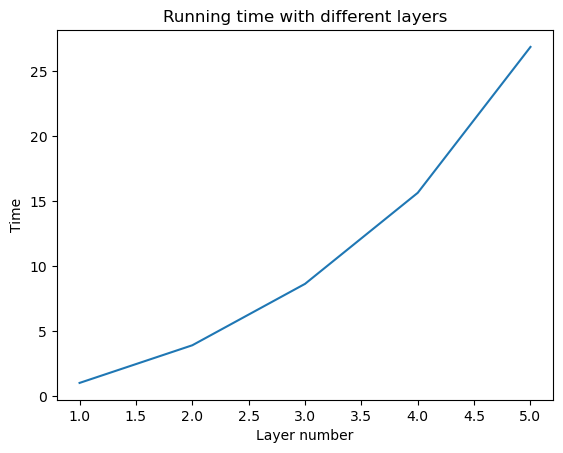

In [53]:
layerset=np.linspace(1,5,5)
layerset=layerset.astype(int)
m0=8
gamma0=0.1
n0=32
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

kr =KernelRidge(kernel="rbf")
for layer in layerset:
    for l in range(layer):  #ml points, nl sampling  
        if l==0:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**(l-1),n_components=m0*2**(l-1))
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr.fit(train_xtransformed, train_y)
                
                yl_kr=yl_kr-kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain-kr.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0 
        
    kernel_fit = time.time() - t0
        
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

plt.plot(layerset,trainmse)
plt.plot(layerset,testmse)
plt.legend(["trainmse","testmse"])
plt.xlabel("Layer number")
plt.ylabel("MSE")
plt.title("MSE with different layers")
plt.show()

plt.plot(layerset,t)
plt.xlabel("Layer number")
plt.ylabel("Time")
plt.title("Running time with different layers")
plt.show()

different layer with cross validation

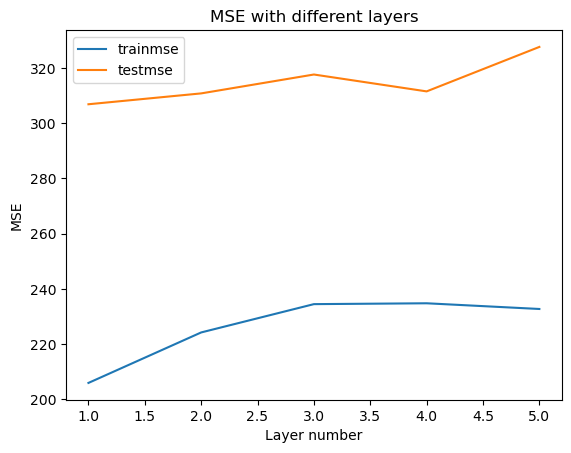

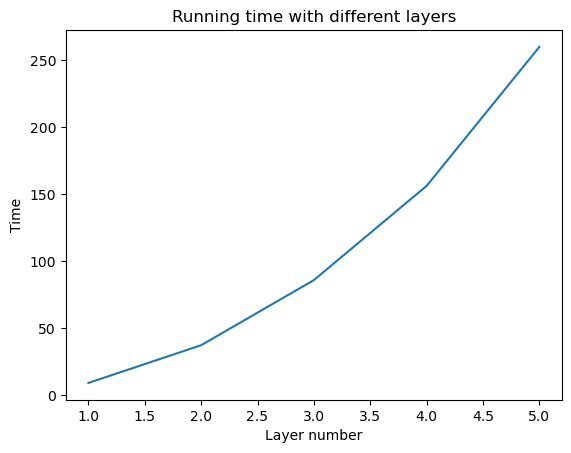

In [54]:
layerset=np.linspace(1,5,5)
layerset=layerset.astype(int)
m0=8
gamma0=0.1
n0=32
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    for l in range(layer):  #ml points, nl sampling  
        if l==0:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr=GridSearchCV(KernelRidge(kernel="rbf"),param_grid={"gamma": np.logspace(-(l+1), -(l), 5,base=5)})
                kr.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr=GridSearchCV(KernelRidge(kernel="rbf"),param_grid={"gamma": np.logspace(-(l+1), -(l), 5,base=5)})
                kr.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**(l-1),n_components=m0*2**(l-1))
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr=GridSearchCV(KernelRidge(kernel="rbf"),param_grid={"gamma": np.logspace(-(l), -(l-1), 5,base=5)})
                kr.fit(train_xtransformed, train_y)
                
                yl_kr=yl_kr-kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain-kr.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0 
        
    kernel_fit = time.time() - t0
        
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

plt.plot(layerset,trainmse)
plt.plot(layerset,testmse)
plt.legend(["trainmse","testmse"])
plt.xlabel("Layer number")
plt.ylabel("MSE")
plt.title("MSE with different layers")
plt.show()

plt.plot(layerset,t)
plt.xlabel("Layer number")
plt.ylabel("Time")
plt.title("Running time with different layers")
plt.show()

## kernel machine 3 - residual learning

one fixed structure

In [8]:
kr =KernelRidge(kernel="rbf")
Layer=4
m0=32
gamma0=0.1
n0=32
t0 = time.time()
for l in range(Layer):  #ml points, nl sampling
    if l==0:
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y)
            if i==0:
                yl_kr=kr.predict(test_xtransformed)
                yl_kltrain=kr.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
        
        y_kr=yl_kr/n0
        y_krtrain=yl_kltrain/n0
        
    else:
        for i in range(n0):
            feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
            train_xtransformed = feature_map_nystroem.fit_transform(train_x)
            test_xtransformed = feature_map_nystroem.fit_transform(test_x)
            kr.fit(train_xtransformed, train_y-y_krtrain) ##fit residual
            if i==0:
                yl_kr=kr.predict(test_xtransformed)
                yl_kltrain=kr.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+kr.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
        y_kr=y_kr+yl_kr/n0
        y_krtrain=y_krtrain+yl_kltrain/n0
kernel_fit = time.time() - t0

krmse=mean_squared_error(train_y,y_krtrain)
print(f"trainMSE: {krmse:.3f}")
krmse=mean_squared_error(test_y,y_kr)
print(f"testMSE: {krmse:.3f}")
print("Kernel machine complexity and model fitted in %.3f s" % kernel_fit)

trainMSE: 170.369
testMSE: 200.548
Kernel machine complexity and model fitted in 6.463 s


different layer

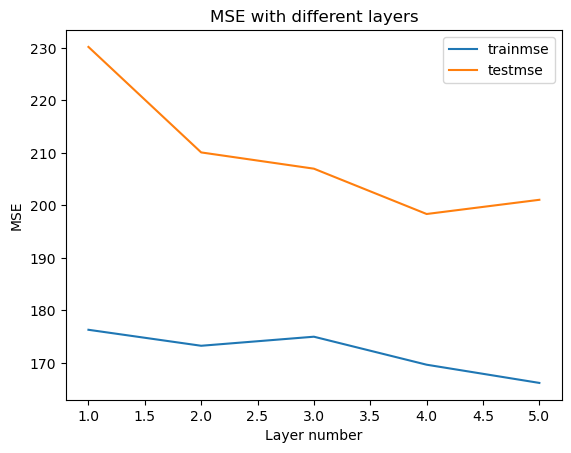

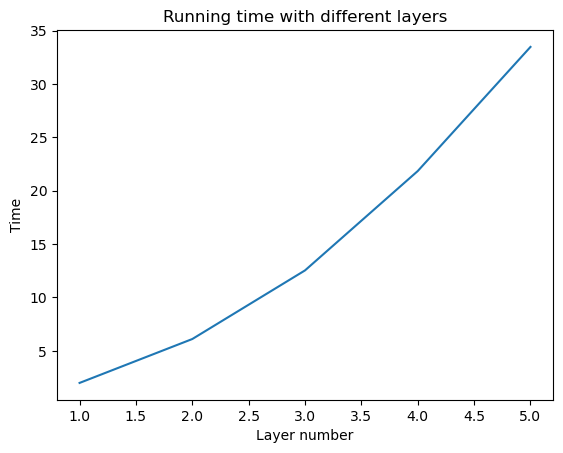

In [13]:
layerset=np.linspace(1,5,5)
layerset=layerset.astype(int)
m0=8
gamma0=0.1
n0=64
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    for l in range(layer):  #ml points, nl sampling
        if l==0:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr.fit(train_xtransformed, train_y-y_krtrain) ##fit residual
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0    
    
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

plt.plot(layerset,trainmse)
plt.plot(layerset,testmse)
plt.legend(["trainmse","testmse"])
plt.xlabel("Layer number")
plt.ylabel("MSE")
plt.title("MSE with different layers")
plt.show()

plt.plot(layerset,t)
plt.xlabel("Layer number")
plt.ylabel("Time")
plt.title("Running time with different layers")
plt.show()

different layer with cross-validation to choose parameter

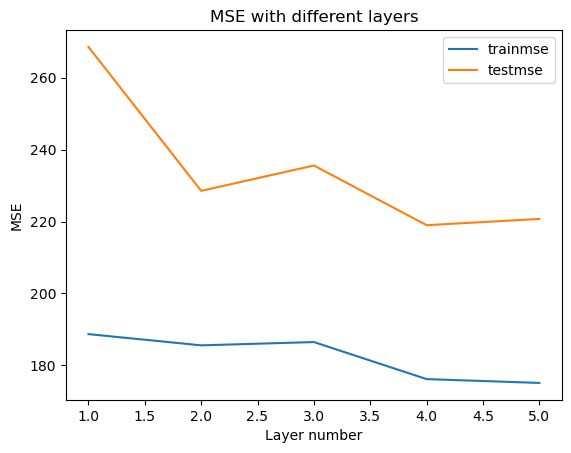

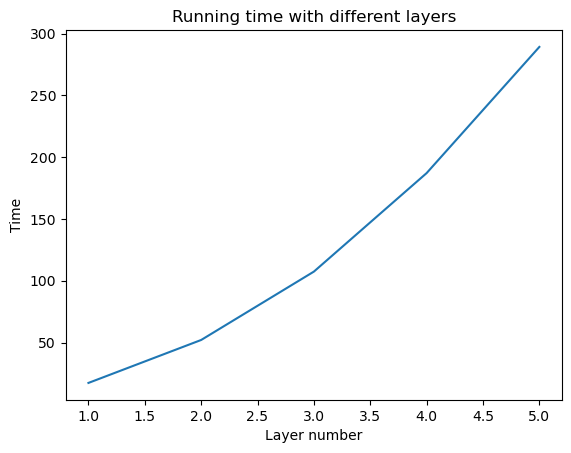

In [44]:
layerset=np.linspace(1,5,5)
layerset=layerset.astype(int)
m0=8
gamma0=0.1
n0=64
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    for l in range(layer):  #ml points, nl sampling
        if l==0:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr=GridSearchCV(KernelRidge(kernel="rbf"),param_grid={"gamma": np.logspace(-(l+1), -(l), 5,base=5)})
                kr.fit(train_xtransformed, train_y)
                if i==0:
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                feature_map_nystroem = Nystroem(gamma=gamma0/2**l,n_components=m0*2**l)
                train_xtransformed = feature_map_nystroem.fit_transform(train_x)
                test_xtransformed = feature_map_nystroem.fit_transform(test_x)
                kr=GridSearchCV(KernelRidge(kernel="rbf"),param_grid={"gamma": np.logspace(-(l+1), -(l), 5,base=5)})
                kr.fit(train_xtransformed, train_y-y_krtrain) ##fit residual
                if i==0:     
                    yl_kr=kr.predict(test_xtransformed)
                    yl_kltrain=kr.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+kr.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+kr.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0    
    
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

plt.plot(layerset,trainmse)
plt.plot(layerset,testmse)
plt.legend(["trainmse","testmse"])
plt.xlabel("Layer number")
plt.ylabel("MSE")
plt.title("MSE with different layers")
plt.show()

plt.plot(layerset,t)
plt.xlabel("Layer number")
plt.ylabel("Time")
plt.title("Running time with different layers")
plt.show()

## Resnet (yet to be finished)

In [220]:
import torchvision
net = torchvision.models.resnet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)
print(net)
criterion=nn.MSELoss() #nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.5) #optim.Adam(...)

for epoch in range(100): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x=x.reshape(64,3,3,10)
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            print(f'''epoch {epoch}
                Train set - loss: {train_loss}
                Test  set - loss: {test_loss}
                ''')
            break

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [10, 90]

Resnet diy

In [146]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)